In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

import talib
from mplfinance.original_flavor import candlestick_ohlc

from matplotlib.pylab import date2num
from datetime import timedelta

from scipy.stats import pearsonr 

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
import sys
sys.version
path = sys.path[0] + '/'
path

'/Users/maitreyasinha/IIT-B Course/Data Mining/Portfolio-Analysis/'

In [3]:
training_window = 60
prediction_window = 5

target_prediction_indices = (0,-3,-2)

cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker']
cols_to_drop = ["Date", "adjclose", "ticker"]
cols_to_keep = [i for i in cols if i not in cols_to_drop]
cols_to_keep

['open', 'high', 'low', 'close', 'volume']

In [4]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    
    #Get the Average True Range
    data['ATR'] = talib.ATR(data['high'], data['low'], data['close'])
    
    # Compute the logarithmic returns using the Closing price 
    data['Log_Ret'] = np.log(data['close'] / data['close'].shift(100))

    # Compute Volatility using the pandas rolling standard deviation function
    data['volatility'] = data['Log_Ret'].rolling(window=100 ).std() * np.sqrt(21)
    
    #Compute the Sharpe Ratio 
    df["Sharpe Ratio"] = df["Log_Ret"]/df["volatility"]
    
    return data.dropna()

In [5]:
def plot_chart(data, n, ticker, save=False):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index , data["close"], label="Closing" ,linewidth=2,)
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.set_ylabel("MACD")
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel(" RSI (%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Plot ATR --> Volatility
    ax_vol.set_ylabel("Volatility")
    ax_vol.plot(data.index, data["ATR"], label="Average True Range")
    ax_vol.legend()
    
    # Save the chart as PNG
    if save:
        fig.savefig(path + ticker + ".jpeg", bbox_inches="tight", dpi=300)
    
    plt.show()

In [6]:
#2005-07-28
stocks = {"YESBANK.NS" : 0.2, "TATAMOTORS.NS":0.2, "HDFCBANK.NS":0.2, "RELIANCE.NS":0.2,"BAJAJ-AUTO.NS":0.2}
stocks_df = {}
df = None
# indices = set([])

for stock in stocks.keys():
    print("pulling data for ", stock)
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    stocks_df[stock] = _df
    if df is None:
        df = _df[cols_to_keep]*stocks.get(stock)
        indices = set(df.index.astype('str').tolist())
    else:
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock)

df.head()

pulling data for  YESBANK.NS
pulling data for  TATAMOTORS.NS
pulling data for  HDFCBANK.NS
pulling data for  RELIANCE.NS
pulling data for  BAJAJ-AUTO.NS


,open,high,low,close,volume
2014-03-25,658.467999,664.665790,653.758409,658.277411,8493168.0
2019-05-16,1129.645996,1142.659995,1122.709995,1135.293964,24777916.8
2017-11-20,1150.230005,1167.779993,1149.560004,1163.654999,3866050.2
2020-05-05,993.290010,1002.491978,969.872005,977.736023,22042944.6
2019-12-18,1255.030011,1266.340000,1248.859995,1260.679971,41984586.2


In [7]:
df.index.min(), df.index.max()
_df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [8]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
# df.drop(["volume"],axis=1,inplace=True)
df.head()

,Date,open,high,low,close,volume
0,2014-03-25,658.467999,664.665790,653.758409,658.277411,8493168.0
1,2019-05-16,1129.645996,1142.659995,1122.709995,1135.293964,24777916.8
2,2017-11-20,1150.230005,1167.779993,1149.560004,1163.654999,3866050.2
3,2020-05-05,993.290010,1002.491978,969.872005,977.736023,22042944.6
4,2019-12-18,1255.030011,1266.340000,1248.859995,1260.679971,41984586.2


In [9]:
df["Date"].min(), df["Date"].max()

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-15 00:00:00'))

In [10]:
mdf = df[:100]
mdf.head()
print(len(mdf))
mdf.sort_values('Date')

100


,Date,open,high,low,close,volume
71,2012-06-29,503.444196,508.727403,499.900591,506.261391,8211258.2
61,2012-07-13,490.439191,493.975806,486.837798,491.024208,5019317.4
34,2012-09-14,553.177591,566.263603,551.855598,562.072401,16052483.0
51,2012-10-10,560.113199,565.486598,556.488208,560.635391,3932569.8
31,2012-10-25,565.821399,573.046400,561.547607,564.938594,11422565.8
...,...,...,...,...,...,...
24,2020-06-19,1100.530003,1134.800010,1090.530005,1119.520020,43686831.0
49,2020-08-28,1287.039989,1296.389970,1271.730000,1280.519962,80173446.2
99,2020-10-15,1341.709980,1356.850001,1303.509990,1308.549980,28488177.6
40,2020-10-16,1313.389999,1334.160001,1302.629980,1312.060005,29286405.8


['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 'macd_hist', 'ma10', 'ma30', 'rsi', 'ATR', 'Log_Ret', 'volatility', 'Sharpe Ratio'] ['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 'macd_hist', 'ma10', 'ma30', 'rsi', 'ATR', 'Log_Ret', 'volatility', 'Sharpe Ratio']


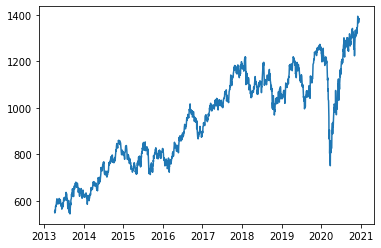

In [11]:
if "Date" in df.columns:
    df.sort_values("Date", inplace=True)
    df= df.set_index("Date")
#     df.index = df.index.sort_values()
    split_date = '2020-01-01'

    df = get_indicators(df)
    df.dropna(inplace=True)
    df_data_training = df[df.index < split_date]
    df_data_test = df[df.index >= split_date]
    
plt.plot(df.index,df["open"])

print(df.columns.to_list() , df_data_training.columns.to_list())
# df.head()

In [12]:
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2013-04-09,552.910202,556.588394,544.042201,549.439191,7516458.0,-19.100873,-17.587090,-1.513782,558.080299,591.424200,28.953101,16.576452,-0.067290,0.440809,-0.152651
2013-04-10,548.529591,557.185002,545.237993,555.579199,6435550.6,-18.155019,-17.700676,-0.454343,556.303578,588.898273,34.229528,16.245777,-0.044446,0.449421,-0.098895
2013-04-11,560.019998,562.732797,549.510406,553.878603,8542662.8,-17.342731,-17.629087,0.286356,554.529279,587.096000,33.487710,16.029821,-0.034822,0.456932,-0.076209
2013-04-12,549.156801,561.877991,547.306198,558.253001,5555212.8,-16.159730,-17.335216,1.175486,553.339598,585.154787,37.254577,15.925676,-0.040025,0.464543,-0.086160
2013-04-15,554.620996,567.554004,552.588399,559.999985,7132245.6,-14.909361,-16.850045,1.940684,552.704756,583.344800,38.746560,15.857100,-0.029734,0.471096,-0.063117


In [13]:
df.index = df.index.sort_values()
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2013-04-09,552.910202,556.588394,544.042201,549.439191,7516458.0,-19.100873,-17.587090,-1.513782,558.080299,591.424200,28.953101,16.576452,-0.067290,0.440809,-0.152651
2013-04-10,548.529591,557.185002,545.237993,555.579199,6435550.6,-18.155019,-17.700676,-0.454343,556.303578,588.898273,34.229528,16.245777,-0.044446,0.449421,-0.098895
2013-04-11,560.019998,562.732797,549.510406,553.878603,8542662.8,-17.342731,-17.629087,0.286356,554.529279,587.096000,33.487710,16.029821,-0.034822,0.456932,-0.076209
2013-04-12,549.156801,561.877991,547.306198,558.253001,5555212.8,-16.159730,-17.335216,1.175486,553.339598,585.154787,37.254577,15.925676,-0.040025,0.464543,-0.086160
2013-04-15,554.620996,567.554004,552.588399,559.999985,7132245.6,-14.909361,-16.850045,1.940684,552.704756,583.344800,38.746560,15.857100,-0.029734,0.471096,-0.063117


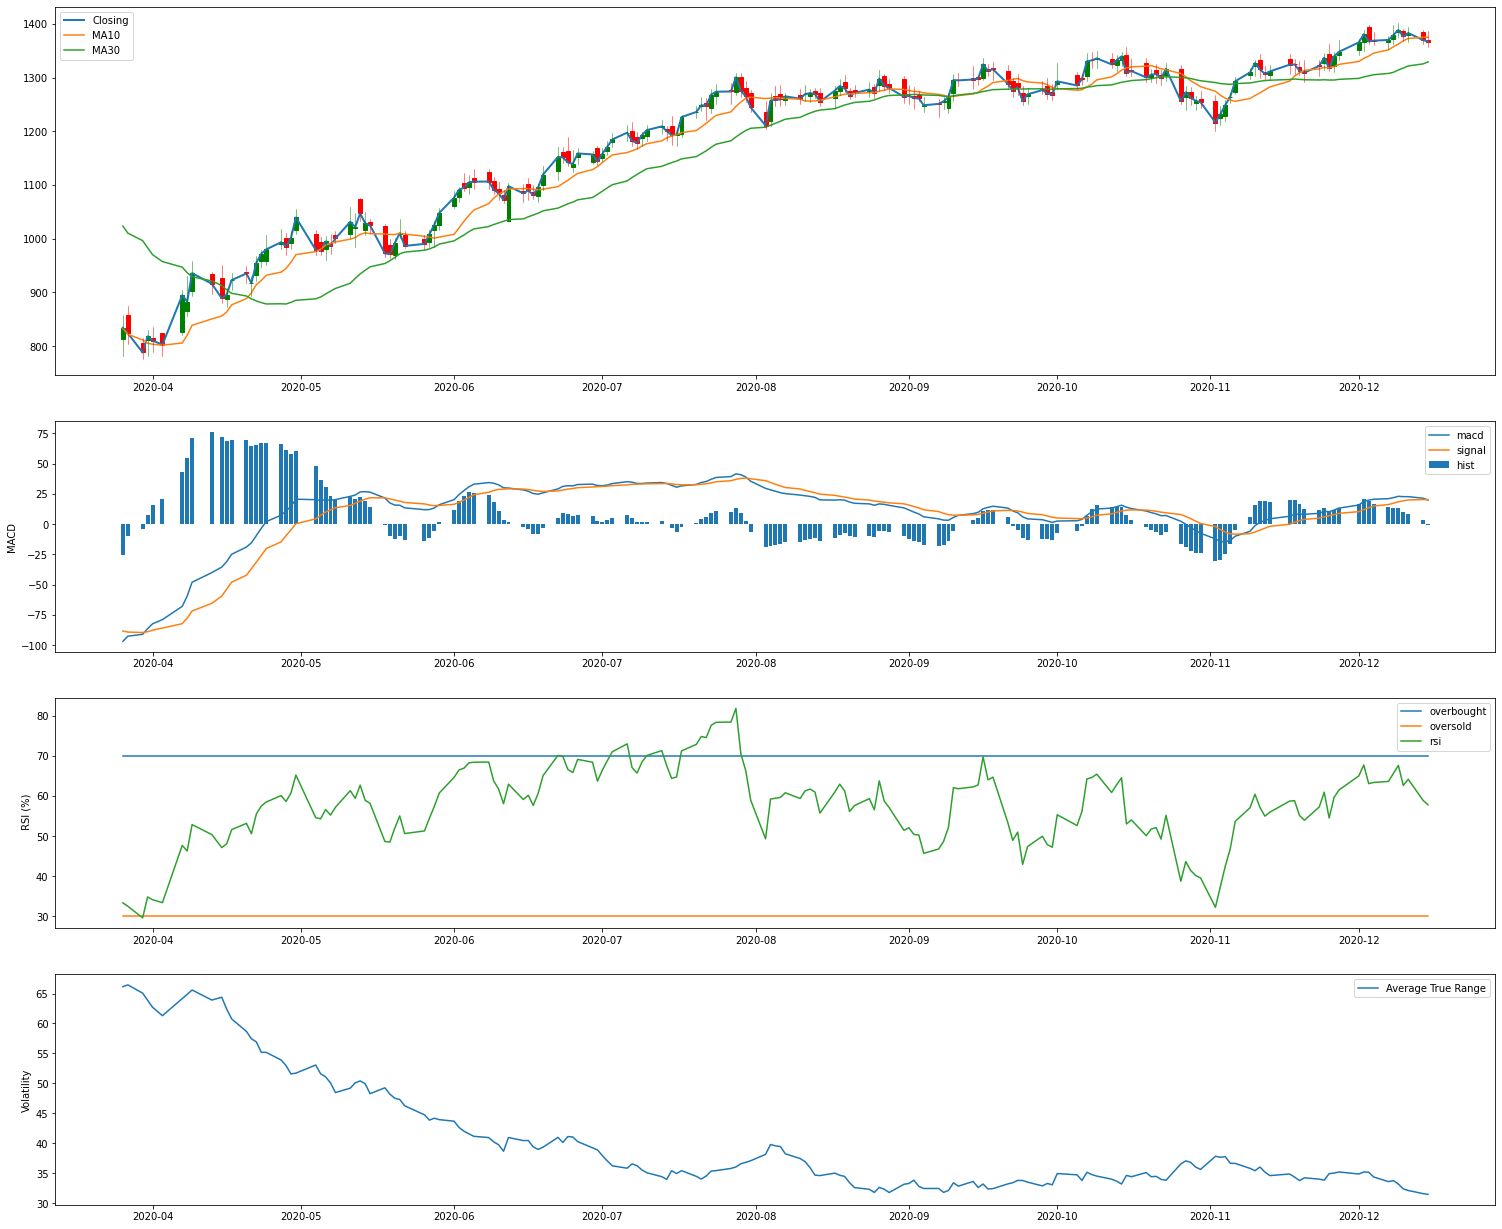

In [14]:
# _df = df.set_index("Date")
plot_chart(df, 180, 'Custom')

Training Size : 1652, Test Size : 239


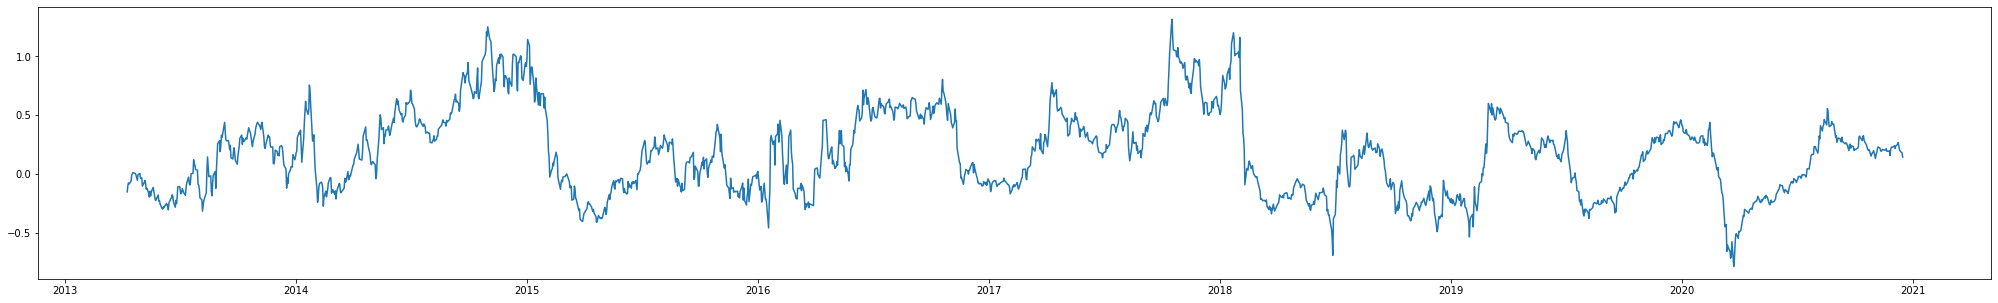

In [15]:
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )
df.head()
plt.figure(figsize=(35,5))
plt.plot(df.index, df["Sharpe Ratio"])

In [16]:
data_training = df_data_training.copy()
data_training.dropna(inplace=True)

## Scaler

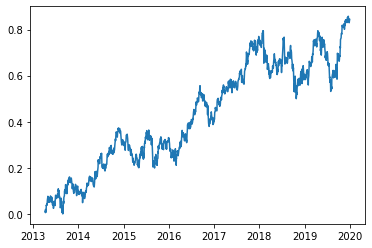

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df)

training_Dataset = scaler.transform(data_training)
_scale = [1/scaler.scale_[i] for i in target_prediction_indices]
_intercept = [scaler.data_min_[i] for i in target_prediction_indices]

plt.plot(data_training.index, training_Dataset[:,0])

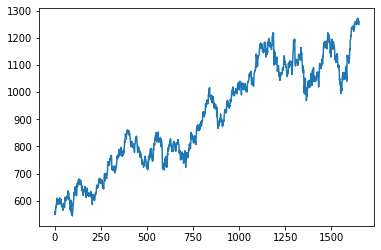

In [18]:
_df = scaler.inverse_transform(training_Dataset)
plt.plot(_df[:,0])
# _df

1652 1891


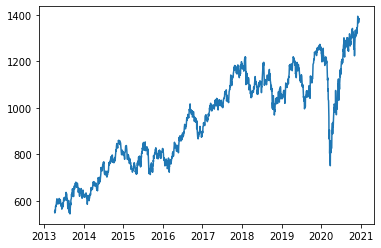

In [19]:
print(len(data_training), len(df))
plt.plot(df.index,df["open"])

## Training Pipeline

In [20]:
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]-prediction_window):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i+prediction_window,target_prediction_indices])
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

Shape of X is : (1587, 60, 15), Shape of Y is : (1587, 3)


In [22]:
print("Shape of data_training.index", data_training.index[training_window:].shape)

Shape of data_training.index (1592,)


In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 0.0070:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [24]:
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,15)),
    Dropout(0.4),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=70, activation='relu'),
    Dropout(0.3),
    Dense(3)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 120)           65280     
_________________________________________________________________
dropout (Dropout)            (None, 60, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 90)            75960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            54720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                4

In [25]:
model_name = path + "daily_predictor.hdf5"
# model.load_weights(model_name)

In [26]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError())
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=25, callbacks = CustomCallback())

Epoch 1/25
50/50 [==============================] - 6s 113ms/step - loss: 0.0361
Epoch 2/25
50/50 [==============================] - 5s 109ms/step - loss: 0.0158
Epoch 3/25
50/50 [==============================] - 6s 113ms/step - loss: 0.0124
Epoch 4/25
50/50 [==============================] - 5s 108ms/step - loss: 0.0104
Epoch 5/25
50/50 [==============================] - 7s 134ms/step - loss: 0.0096
Epoch 6/25
50/50 [==============================] - 7s 139ms/step - loss: 0.0085
Epoch 7/25
50/50 [==============================] - 5s 110ms/step - loss: 0.0072
Epoch 8/25
50/50 [==============================] - 6s 113ms/step - loss: 0.0070
Epoch 9/25
50/50 [==============================] - ETA: 0s - loss: 0.0064
Final Loss : 0.006418558768928051
50/50 [==============================] - 6s 125ms/step - loss: 0.0064


In [27]:
# model.save(model_name)
# scaler.data_min_[0]
test_pred = model.predict(X_train)
test_pred * _scale + _intercept
# test_pred

array([[6.29997894e+02, 2.73695712e-03, 2.71968026e-01],
       [6.30093083e+02, 3.09834689e-03, 2.71855160e-01],
       [6.30186731e+02, 3.52979882e-03, 2.71710595e-01],
       ...,
       [1.10591137e+03, 8.72576905e-02, 3.45962206e-01],
       [1.10580476e+03, 8.83412933e-02, 3.47557615e-01],
       [1.10572659e+03, 8.94397520e-02, 3.49035588e-01]])

In [28]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred
test_pred = test_pred * _scale + _intercept
y_train = y_train * _scale + _intercept

y_train

50/50 [==============================] - 2s 42ms/step - loss: 0.0050


array([[ 6.08179591e+02, -2.69286782e-02,  3.40578438e-01],
       [ 6.07900787e+02, -9.00031649e-03,  3.36083670e-01],
       [ 6.08767209e+02, -2.51406498e-02,  3.31094856e-01],
       ...,
       [ 1.24915000e+03,  1.86514334e-01,  4.74289290e-01],
       [ 1.25860999e+03,  2.22040650e-01,  4.82298027e-01],
       [ 1.26124999e+03,  2.17563273e-01,  4.88787057e-01]])

In [29]:
y_train[:,2]

array([0.34057844, 0.33608367, 0.33109486, ..., 0.47428929, 0.48229803,
       0.48878706])

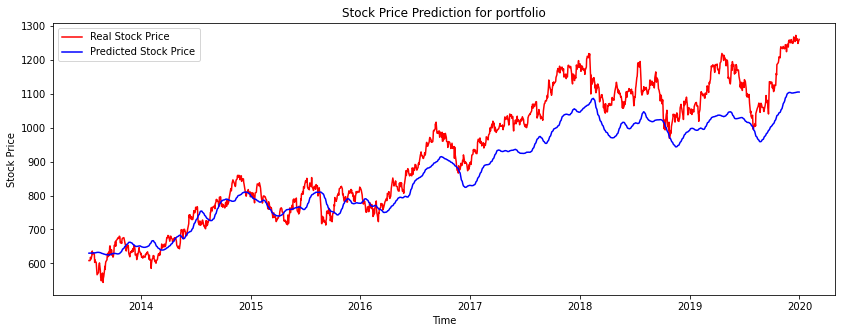

In [30]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(data_training.index[training_window+prediction_window:], y_train[:,0], color = 'red', label = 'Real Stock Price')
plt.plot(data_training.index[training_window+prediction_window:], test_pred[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,y_train.max()*1.1)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/training_output.jpeg", dpi=300)
plt.show()

In [64]:
past_60_days = df_data_training.tail(training_window)
df_data_test.shape

(239, 15)

In [65]:

df_test = past_60_days.append(df_data_test).sort_index()
df_test.dropna(inplace=True)
df_test.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2019-10-01,1134.700000,1147.769990,1108.890015,1122.200015,173463121.4,19.226641,14.566661,4.659980,1113.142601,1081.084265,59.522002,30.967373,-0.049109,0.407729,-0.120446
2019-10-03,1117.759991,1133.029990,1105.600005,1119.480000,132846895.4,18.381696,15.329668,3.052028,1119.841001,1082.940398,58.512182,30.714703,-0.028057,0.404647,-0.069337
2019-10-04,1127.870010,1134.579991,1100.780006,1104.629996,112950881.2,16.325609,15.528856,0.796752,1126.358997,1084.266398,53.205056,30.935080,-0.038763,0.402544,-0.096296
2019-10-07,1107.079966,1121.610015,1099.389985,1110.490010,81378225.8,14.996132,15.422311,-0.426179,1125.968999,1085.772865,54.941831,30.312576,-0.028916,0.399248,-0.072427
2019-10-09,1111.749986,1128.399995,1103.349999,1121.780025,81061969.6,14.684252,15.274700,-0.590448,1124.648005,1088.218532,58.163495,29.936678,-0.013274,0.396355,-0.033491


In [33]:
inputs = scaler.transform(df_test)
inputs

array([[0.69503306, 0.70049707, 0.68505406, ..., 0.43087575, 0.29586994,
        0.3170678 ],
       [0.67511502, 0.68303465, 0.68115734, ..., 0.45080956, 0.29278364,
        0.34138216],
       [0.68700236, 0.68487093, 0.6754485 , ..., 0.44067192, 0.29067807,
        0.32855667],
       ...,
       [0.98283338, 0.99276149, 0.98928111, ..., 0.5742441 , 0.41169434,
        0.46735452],
       [0.98792452, 0.98474113, 0.98591737, ..., 0.56562484, 0.41020144,
        0.45932268],
       [0.97140458, 0.9827271 , 0.97772127, ..., 0.54832612, 0.41159838,
        0.44248768]])

In [34]:
X_test = []
y_test = []

for i in range(training_window, inputs.shape[0]-prediction_window):
    X_test.append(inputs[i-training_window:i])
    y_test.append(inputs[i+prediction_window, target_prediction_indices])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((234, 60, 15), (234, 3))

In [35]:
y_pred = model.predict(X_test)
y_pred.shape

(234, 3)

In [36]:
scaler.scale_

array([1.17579887e-03, 1.18469571e-03, 1.18440808e-03, 1.19105954e-03,
       4.28766698e-09, 6.91456532e-03, 7.84613655e-03, 2.08577301e-02,
       1.21616886e-03, 1.32302572e-03, 1.37189709e-02, 1.82746264e-02,
       9.46873131e-01, 1.00127891e+00, 4.75737679e-01])

In [37]:
y_pred = y_pred* _scale + _intercept
y_test = y_test* _scale + _intercept
y_pred.shape

(234, 3)

In [38]:
model.evaluate(X_test,  y_test)

8/8 [==============================] - 0s 36ms/step - loss: 465225.2188


465225.21875

In [39]:
y_test.max()

1394.069990158081

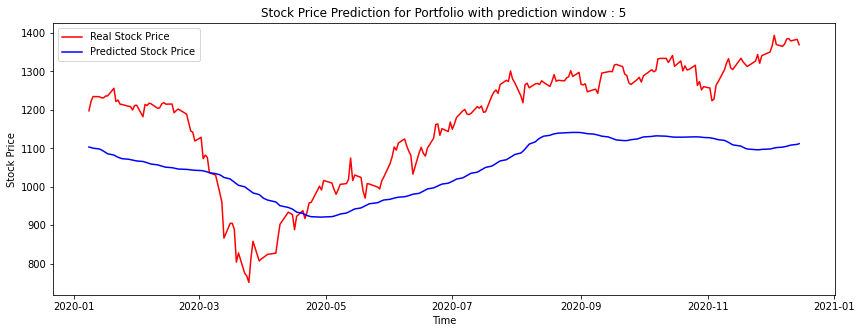

In [40]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(df_test.index[training_window+prediction_window:], y_test[:,0], color = 'red', label = 'Real Stock Price')
plt.plot(df_test.index[training_window+prediction_window:], y_pred[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for Portfolio with prediction window : '+ str(prediction_window))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
y_test
# plt.ylim(0,y_test.max()*1.1)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/test_output.jpeg", dpi=300)
plt.show()

## Portfolio Analysis and Co-relation

In [41]:
#Analyze portfolio with external Stock
external_stock = "BATAINDIA.NS"


In [42]:
analyze_stocks_df = stocks_df.copy()
if external_stock:
    analyze_stocks_df[external_stock] = si.get_data(external_stock)
    
stock = list(analyze_stocks_df.keys())
num_stocks = len(stock)
num_stocks

6

In [43]:
df = None
for st in stock:
    if df is None:
        df = analyze_stocks_df[st].copy()
        df[st] = (df["open"] + df["close"])/2
        df = pd.DataFrame(df[st])
    else:
        _df = analyze_stocks_df[st]
        df[st] = (_df["open"] + _df["close"])/2
        
df.dropna(inplace=True)        
df.head()

,YESBANK.NS,TATAMOTORS.NS,HDFCBANK.NS,RELIANCE.NS,BAJAJ-AUTO.NS,BATAINDIA.NS
2012-06-18,67.085003,237.923004,271.737503,362.312500,1540.974976,402.687500
2012-06-19,64.815002,236.043503,267.812500,363.612503,1537.700012,397.925003
2012-06-20,65.750000,240.890999,267.800003,368.850006,1535.099976,406.287506
2012-06-21,67.389999,243.958496,268.975006,363.175003,1534.025024,416.550003
2012-06-22,67.815002,243.364998,269.862488,356.137497,1534.700012,424.649994


In [44]:
stock_ret = df.pct_change()*100

mean_returns = stock_ret.mean()
cov_matrix = stock_ret.cov()


In [45]:
#Set the number of iterations to 10000 and define an array to hold the simulation results; initially set to all zeros
num_iterations = 10000
simulation_res = np.zeros((4+num_stocks-1,num_iterations))

In [46]:
for i in range(num_iterations):
#Select random weights and normalize to set the sum to 1
    weights = np.array(np.random.random(num_stocks))
    weights /= np.sum(weights)
#Calculate the return and standard deviation for every step
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
#Store all the results in a defined array
    simulation_res[0,i] = portfolio_return
    simulation_res[1,i] = portfolio_std_dev
#Calculate Sharpe ratio and store it in the array
    simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
#Save the weights in the array
    for j in range(len(weights)):
        simulation_res[j+3,i] = weights[j]

In [47]:
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe']+stock)
sim_frame.head()

,ret,stdev,sharpe,YESBANK.NS,TATAMOTORS.NS,HDFCBANK.NS,RELIANCE.NS,BAJAJ-AUTO.NS,BATAINDIA.NS
0,0.037483,1.274185,0.029418,0.215937,0.180442,0.032321,0.105457,0.324720,0.141123
1,0.057544,1.056710,0.054456,0.037691,0.193587,0.197260,0.155807,0.203422,0.212234
2,0.045994,1.252457,0.036723,0.197008,0.203052,0.135994,0.243300,0.150924,0.069721
3,0.044368,1.316601,0.033699,0.221093,0.223206,0.144663,0.162313,0.066798,0.181928
4,0.036794,1.435779,0.025627,0.290031,0.199068,0.114089,0.093983,0.134951,0.167879


In [48]:
#Spot the position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

In [49]:
#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
print("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print("The portfolio for min risk:\n", min_std)

The portfolio for max Sharpe Ratio:
 ret              0.081951
stdev            1.029739
sharpe           0.079584
YESBANK.NS       0.009082
TATAMOTORS.NS    0.016739
HDFCBANK.NS      0.310912
RELIANCE.NS      0.383650
BAJAJ-AUTO.NS    0.031094
BATAINDIA.NS     0.248523
Name: 923, dtype: float64
The portfolio for min risk:
 ret              0.068589
stdev            0.962407
sharpe           0.071268
YESBANK.NS       0.014071
TATAMOTORS.NS    0.022474
HDFCBANK.NS      0.281978
RELIANCE.NS      0.173584
BAJAJ-AUTO.NS    0.312390
BATAINDIA.NS     0.195503
Name: 8364, dtype: float64


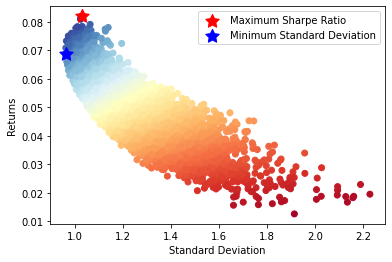

In [50]:
#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=200, label="Maximum Sharpe Ratio")
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=200, label="Minimum Standard Deviation")
plt.legend()

In [51]:
max_sharpe = simulation_res[2,:].max()

for it in range(num_iterations):
    if simulation_res[2,it] == max_sharpe:
        break

print("Optimum Allocation")
a = list(zip(stock,simulation_res[:,it][-num_stocks:]))
extended_stock_df = dict(a)
extended_stock_df

Optimum Allocation


{'YESBANK.NS': 0.009082271052162756,
 'TATAMOTORS.NS': 0.016738593273903354,
 'HDFCBANK.NS': 0.31091161763657327,
 'RELIANCE.NS': 0.3836503276970085,
 'BAJAJ-AUTO.NS': 0.03109416318607474,
 'BATAINDIA.NS': 0.24852302715427746}

In [52]:
extended_stock_df

{'YESBANK.NS': 0.009082271052162756,
 'TATAMOTORS.NS': 0.016738593273903354,
 'HDFCBANK.NS': 0.31091161763657327,
 'RELIANCE.NS': 0.3836503276970085,
 'BAJAJ-AUTO.NS': 0.03109416318607474,
 'BATAINDIA.NS': 0.24852302715427746}

# Analyze Stock Future with predictor  -- Loop

In [53]:
df = None
for stock in extended_stock_df.keys():
    print("pulling data for ", stock)
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    stocks_df[stock] = _df
    if df is None:
        df = _df[cols_to_keep]*extended_stock_df.get(stock)
        indices = set(df.index.astype('str').tolist())
    else:
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*extended_stock_df.get(stock)

df.head()

pulling data for  YESBANK.NS
pulling data for  TATAMOTORS.NS
pulling data for  HDFCBANK.NS
pulling data for  RELIANCE.NS
pulling data for  BAJAJ-AUTO.NS
pulling data for  BATAINDIA.NS


,open,high,low,close,volume
2014-03-25,496.794356,500.179032,492.399883,495.458972,7.047922e+06
2019-05-16,1262.372819,1280.484211,1258.976568,1273.870935,5.215456e+06
2017-11-20,928.253124,939.269085,923.914215,934.210496,2.282359e+06
2020-05-05,1253.292824,1268.190252,1220.959008,1229.870028,1.396959e+07
2019-12-18,1520.411307,1533.172974,1508.816306,1522.939594,7.651139e+06


In [54]:
get_indicators(df)
df.dropna(inplace=True)
df = df.sort_index()
dataset = scaler.transform(df)
dataset.max()

11.523820993600996

In [55]:
X = []
for i in range(-prediction_window,0):
    X.append(dataset[i-training_window:i])

In [56]:
Y = model.predict(np.array(X)) * _scale + _intercept
Y

array([[-1.29870367e+05,  1.77300439e+03,  1.28254036e+03],
       [-8.34862118e+04,  1.75417572e+03,  1.26647448e+03],
       [-5.05515185e+04, -2.74951483e+01,  1.42972500e+02],
       [-2.55531690e+05,  3.68686311e+03,  2.24090930e+03],
       [-1.47583517e+05,  1.45888236e+03,  1.25915255e+03]])

In [57]:
dt = df.index[-prediction_window:] + timedelta(prediction_window)

Text(0.5, 1.0, 'Projected Prices of Optimised Portfolio')

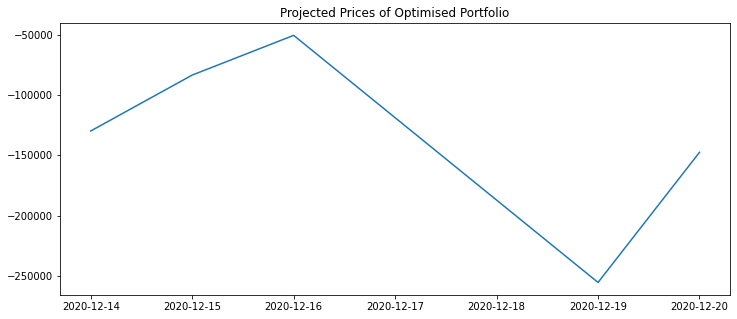

In [58]:
# Y[:,0]
plt.figure(figsize=(12,5))
plt.plot(dt, Y[:,0])
plt.title("Projected Prices of Optimised Portfolio")

## Asset Correlation

In [59]:

def get_correlation(s1,s2):
#     s1 = 'RELIANCE.NS'
#     s2 = "YESBANK.NS"

    stock1 = stocks_df[s1]["close"][-training_window-prediction_window:]
    stock2 = stocks_df[s2]["close"][-training_window-prediction_window:]

    real = pearsonr(stock1, stock2)
    return real[0]

get_correlation('RELIANCE.NS', "YESBANK.NS")

-0.27741205670532476

In [60]:
list(stocks_df.keys())

['YESBANK.NS',
 'TATAMOTORS.NS',
 'HDFCBANK.NS',
 'RELIANCE.NS',
 'BAJAJ-AUTO.NS',
 'BATAINDIA.NS']

In [61]:
data = {'Name':['Tom', 'nick', 'krish', 'jack'], 'Age':[20, 21, 19, 18]} 
data = pd.DataFrame(data)
data = data.set_index("Name")

data.loc["Tom"]["Age"] = 2
data

,Age
Name,
Tom,2
nick,21
krish,19
jack,18


In [62]:
index = list(stocks_df.keys())
data = {}

for st1 in index:
#     for st2 in index:
    data[st1] = [get_correlation(st1, st2) for st2 in index]

data['index'] = index
data = pd.DataFrame(data)
data.set_index('index', inplace=True)

In [63]:
data

,YESBANK.NS,TATAMOTORS.NS,HDFCBANK.NS,RELIANCE.NS,BAJAJ-AUTO.NS,BATAINDIA.NS
index,,,,,,
YESBANK.NS,1.000000,0.795574,0.491136,-0.277412,0.807010,0.785723
TATAMOTORS.NS,0.795574,1.000000,0.753957,-0.550978,0.841361,0.906013
HDFCBANK.NS,0.491136,0.753957,1.000000,-0.816138,0.635006,0.739804
RELIANCE.NS,-0.277412,-0.550978,-0.816138,1.000000,-0.360236,-0.528064
BAJAJ-AUTO.NS,0.807010,0.841361,0.635006,-0.360236,1.000000,0.899788
BATAINDIA.NS,0.785723,0.906013,0.739804,-0.528064,0.899788,1.000000
